In [7]:
import numpy as np
from PIL import Image
from scipy.linalg import solve
import time
import matplotlib.pyplot as plt

In [8]:
DATA_PATH = '../../../OneDrive - m.titech.ac.jp/Lab/data/'

In [9]:
def calc_err(f, temp, n):
    image = f[:n ** 2].reshape((n, n))
    diff = temp - image
    fenzi = np.linalg.norm(diff, 'fro')
    fenmu = np.linalg.norm(image, 'fro')

    error = fenzi / fenmu
    return error, image

In [10]:
# Parameter
object = 'hadamard64_72R'
s = 128  # input
n = 64  # output
eps = 0.01
# Image range
r1 = 460
r2 = 920
c1 = 400
c2 = 860
# Hyper-parameters in the ADMM implementation
mu1 = 10
mu2 = 1.0e-1
tau = 1.0e-3

In [19]:
# load system matrix
H = np.load(DATA_PATH + 'systemMatrix/H_matrix_FISTA_10p.npy')
HTH = H.T @ H

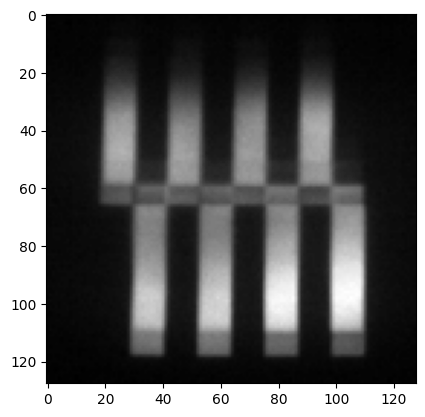

In [20]:
# read captured image and stretch
g = Image.open(f'{DATA_PATH}capture_230516/{object}.png')
g = g.convert('L')
g = g.crop((c1, r1, c2, r2))
g = g.resize((s, s))
g = np.array(g).astype(np.float64) / 255
Image.fromarray((g * 255).astype(np.uint8)).save(f'{DATA_PATH}bef_reconst/cap_230516/{object}.png')
plt.figure(1)
plt.imshow(g, cmap='gray')
plt.show()
g_col = g.reshape(-1, 1)

In [21]:
Dy = np.eye(n ** 2) - np.roll(np.eye(n ** 2), 1, axis=1)
Dx = np.eye(n ** 2) - np.roll(np.eye(n ** 2), n, axis=1)
D0 = np.zeros((n ** 2, n ** 2))
D = np.vstack((Dy, Dx))
DTD = D.T @ D

In [22]:
def Psi(f):
    return D @ f


def SoftThresh(x, t):
    return np.maximum(np.abs(x) - t, 0) * np.sign(x)


def R_k(W, Z, rho_w, rho_z, G, xi):
    return H.T @ (mu1 * G - xi) + D.T @ (mu2 * Z - rho_z) + mu2 * W - rho_w

In [23]:
# get init matrices
G = np.zeros((s ** 2, 1))
Z = np.zeros((2 * n ** 2, 1))
f = np.zeros((n ** 2, 1))
W = np.zeros((n ** 2, 1))
xi = np.zeros((s ** 2, 1))
rho_z = mu2 * Psi(f)
rho_w = W

temp = np.zeros((n, n))

In [24]:
err = []
iters = 0

divmat = 1 / (1 + mu1)

while iters < 200:
    iters += 1

    # f_update f <- argmin_f L
    f1 = mu1 * HTH + mu2 * DTD + mu2 * np.eye(n ** 2)
    f2 = R_k(W, Z, rho_w, rho_z, G, xi)
    f = solve(f1, f2)

    # Z_update z <- argmin_z L
    Z = SoftThresh(Psi(f) + rho_z / mu2, tau / mu2)  # Proximal operator

    # W_update 0<=W<=1
    W = np.clip(f + rho_w / mu2, 0, 1)

    # G_update
    G = divmat * (mu1 * H @ f + g_col)

    # eta_update
    rho_z = rho_z + mu2 * (Psi(f) - Z)  # Lagrange multipliers associated with Z

    # rho_update
    rho_w = rho_w + mu2 * (f - W)  # Lagrange multipliers associated with W

    # calculate error
    error, temp = calc_err(f, temp, n)
    err.append(error)
    print(f'Iteration= {iters},  e = {error}')

    if error < eps:
        break

/var/folders/z4/4tbmcwqj48d2t_nhbrg47xpm0000gq/T/ipykernel_7504/1702385797.py:7: RuntimeWarning: invalid value encountered in scalar divide
  error = fenzi / fenmu


Iteration= 1,  e = nan
Iteration= 2,  e = 1.0
Iteration= 3,  e = 0.4822499519072608
Iteration= 4,  e = 0.31313727357565485
Iteration= 5,  e = 0.22797006179721888
Iteration= 6,  e = 0.17716086115523902
Iteration= 7,  e = 0.143435796483042
Iteration= 8,  e = 0.11636766228233485
Iteration= 9,  e = 0.08790864321980636
Iteration= 10,  e = 0.06405659975855717
Iteration= 11,  e = 0.05416561601473504
Iteration= 12,  e = 0.04815806405678127
Iteration= 13,  e = 0.04235876394203971
Iteration= 14,  e = 0.03671459866688093
Iteration= 15,  e = 0.03166380292248018
Iteration= 16,  e = 0.02748871237648313
Iteration= 17,  e = 0.024364021033232902
Iteration= 18,  e = 0.021647968765629643
Iteration= 19,  e = 0.01909550083586783
Iteration= 20,  e = 0.017078201895071882
Iteration= 21,  e = 0.015461726166249488
Iteration= 22,  e = 0.014131031614301405
Iteration= 23,  e = 0.013082785139040877
Iteration= 24,  e = 0.012143170429016886
Iteration= 25,  e = 0.011195686506820453
Iteration= 26,  e = 0.01039574360577

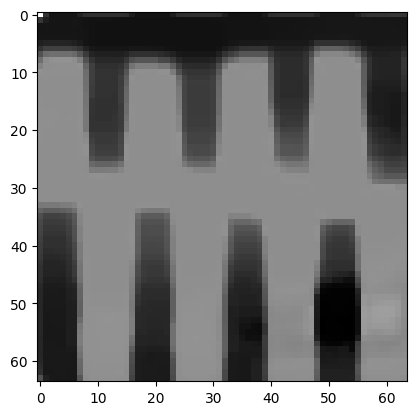

In [25]:
F = np.zeros((n, n))
F = temp

plt.figure(2)
plt.imshow(F, cmap='gray')
plt.show()
Image.fromarray((F * 255).astype(np.uint8)).save(f'{DATA_PATH}reconst/ADMM_240408/1e-2{object}!t{int(np.log10(tau))},m1{int(np.log10(mu1))},m2{int(np.log10(mu2))}_10p.png')


In [26]:

x_axis = np.arange(1, iters + 1)
plt.figure(3)
plt.plot(x_axis, err[0, :iters])
plt.savefig(f'{DATA_PATH}reconst/ADMM_240408/1e-2{object}!t{int(np.log10(tau))},m1{int(np.log10(mu1))},m2{int(np.log10(mu2))}_gr.png')
plt.show()

TypeError: list indices must be integers or slices, not tuple

<Figure size 640x480 with 0 Axes>